In [1]:
%load_ext autoreload
%autoreload 2

## AGN DCR Metric
<br>**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 12-04-20
<br>**Short description:**
This notebook visualize/analyze result of running the [00_DCR_Precision.ipynb](./00_DCR_Precision.ipynb), where the metric draws heavily from Peter Yoachim's `DcrPrecisionMetric` found [here](https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/dcrMetric.py). For some more context, you can also checkout this notebook -> [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb) but with a focus on the integration with MAF and provide the ability to use more realistic astrometric errors simulated by OpSim. 

### 0. Software Setup

In [2]:
# import matplotlib to show plots inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

## 1. Compare DCR metric to desired slopes
### 1.1 Load in simulated DCR data (used to define metric)

Files created by Tina Peters as part of the efforts discussed at [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb), which records the means colors and DCR slopes as a function of redshift for SDSS quasars.  There seems to be some discrepancy between the g-band slopes and the plots of Kaczmarczik et al. 2009, so they should be double-checked before finalizing any quasar-specific DCR metric.

In [5]:
# load in data and merge into one df
dcr_data_dir = '../data/DCR_data/'
dfZ = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshifts.dat'))
dfQSO = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshiftfit.dat'), \
                                index_col=0, header=None, sep=' ').T.dropna().reset_index(drop=True)
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
0,0.40,0.3790,0.1143,0.1995,0.2466,0.0012,0.0258
1,0.45,0.2507,0.0644,0.2651,0.2032,0.0053,0.0506
2,0.50,0.2023,0.0410,0.2679,0.1762,0.0002,0.0589
3,0.55,0.3056,0.0252,0.2351,0.1314,-0.0140,0.0357
4,0.60,0.3419,0.0727,0.1867,0.1570,-0.0083,0.0143


### 1.2 Load in metric results

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RNAAS/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RNAAS/MetricData/'

In [7]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [8]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'DCR_20_g'), (2, 'DCR_22_g'), (3, 'DCR_24_g'), (4, 'DCR_20.15_u'), (5, 'DCR_22.15_u'), (6, 'DCR_24.15_u')]


__Note:__ The keys you see (in your own notebbook) could be different than what are shown above, which as a result you will need to modify the plotting code below to make the cell run properly.

## 2. Make plots
### 2.1 Histplots

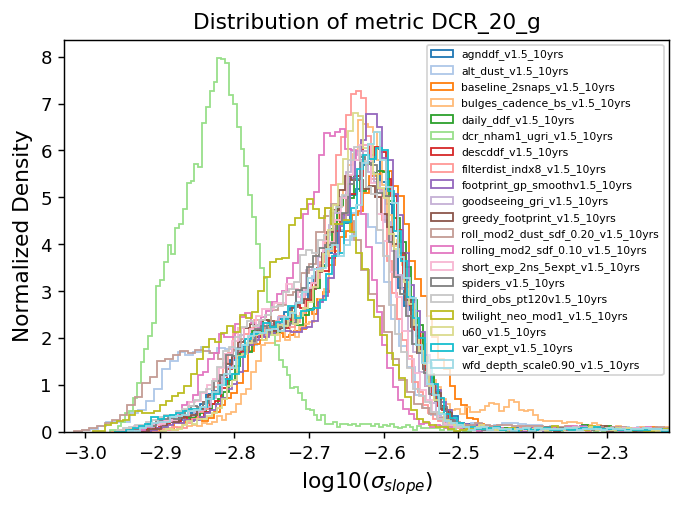

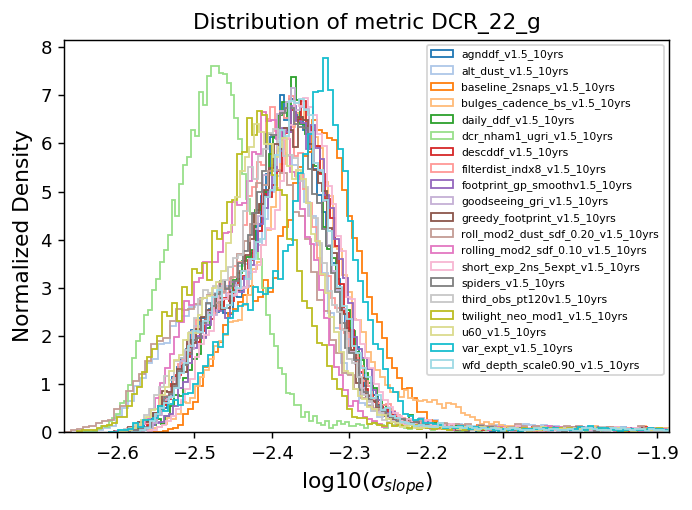

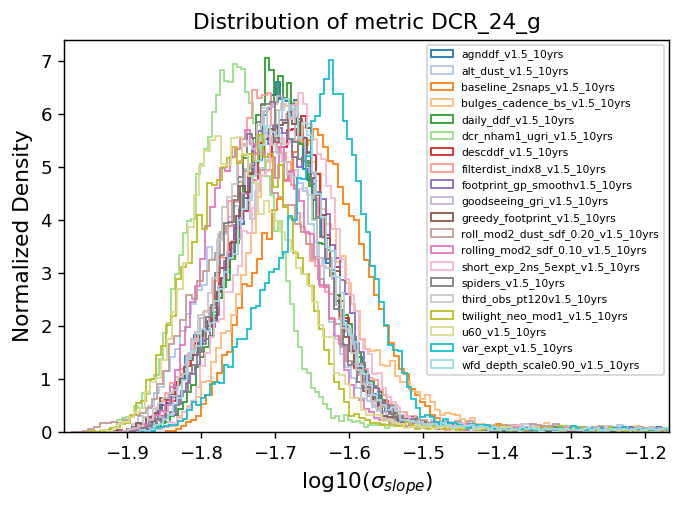

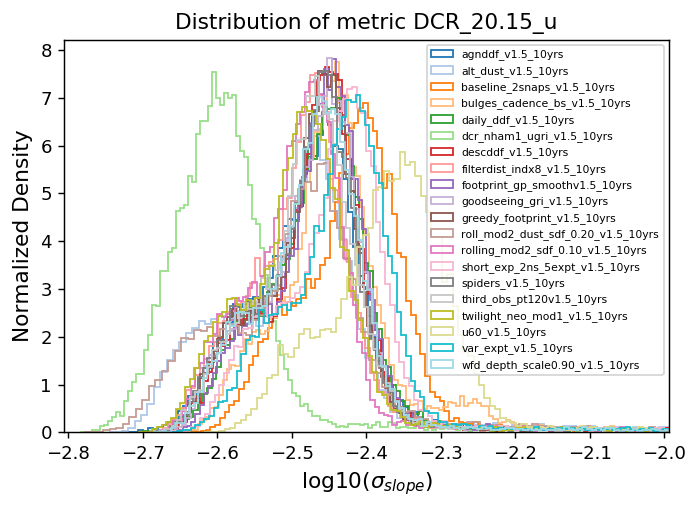

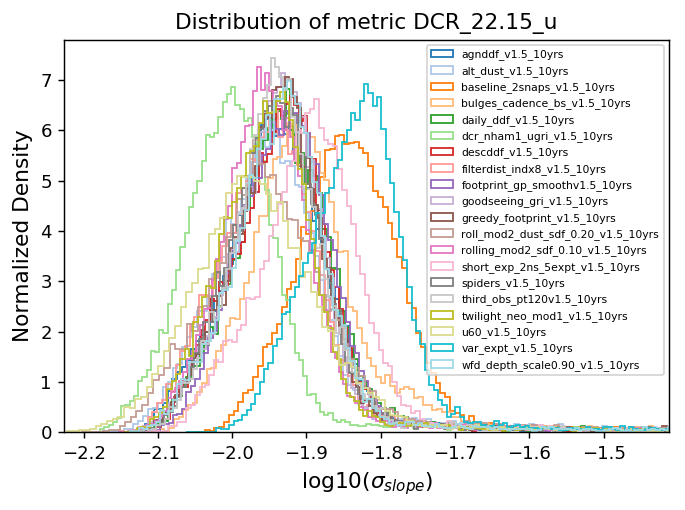

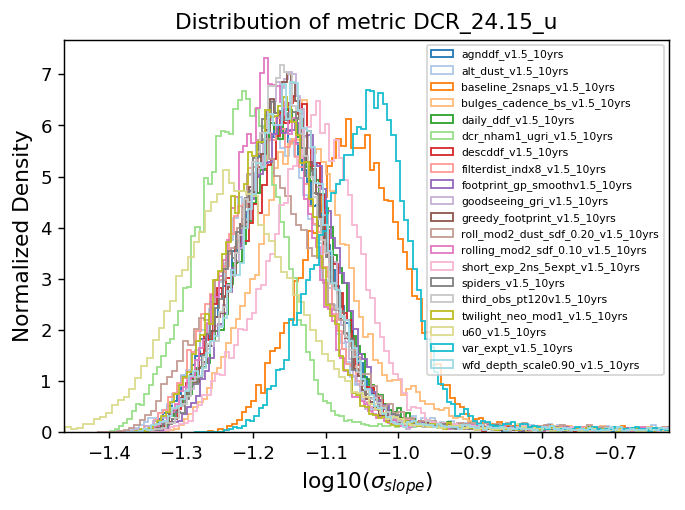

In [9]:
# loop though each metric to make plots, since some values are fairly large 
# and built in functions doesn't allow log scale

# options to provide same xlim for all metric plots
# provide a number if you want uniform xlim for all plots
xMax = None
xMin = None

# whether to save as PNGs
savefig = False

for key in bd_keys:
    fig = plt.figure(dpi=130)
    for i, run in enumerate(resultDbsView):
        
        # look for the correct combination of metricID and metricName 
        keys = [*bundleDicts[run].keys()]
        metricKey = [elem for elem in keys if elem[1] == key[1]][0]
        
        # need to mask the pixels that have no available data
        mask = bundleDicts[run][metricKey].metricValues.mask
        data = bundleDicts[run][metricKey].metricValues.data[~mask]
        data = data[~(np.isnan(data) | np.isinf(data))]

        # plot
        _ = plt.hist(np.log10(data), bins='fd', histtype='step', color=mpl.cm.tab20.colors[i], \
                     density=True, label=f'{run}')
        plt.xlabel('log10($\\sigma_{slope}$)', fontsize=12)
        plt.ylabel('Normalized Density', fontsize=12)
        plt.legend(fontsize=6)
        plt.xlim(right = np.log10(np.percentile(data, 99)))

    # check if uniform xlim provided
    if xMax is not None:
        plt.xlim(right=xMax)
    if xMin is not None:
        plt.xlim(left=xMin)

    plt.title(f'Distribution of metric {key[1]}', fontsize=12)
    # options to save
    if savefig:
        plt.savefig(f'Distribution of metric {key[1]}.png', dpi=200)

### 2.2 Slope SNR plot
Plots in this section will show the SNR for the slope of the best-fit DCR line. With the SNR defined as:

    SNR = QSO_DCR_slope/slope_uncertainty

Eash figure plot the SNR for twenty different cadence simulations (with each being the only one in their familiy) and for both u and g bands, given a fixed u-g color of 0.15.
Note that we take the absolute value because the slope (and thus the SNR) can be negative and it is easier to see when one or both the u and g SNRs are significantly larger than 0.

In [10]:
# return median metric data
def get_dcr_median(mb):
    
    mask = mb.metricValues.mask
    data = mb.metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    return np.median(data)

# get the median values from all opsims 
# for normaliation in plotting
def get_metric_medians(key, bd, func):
    
    mds = []
    for run in bd:
        keys = [*bd[run].keys()]
        run_key = [elem for elem in keys if elem[1] == key[1]][0]
        mds.append(func(bd[run][run_key]))

    return mds

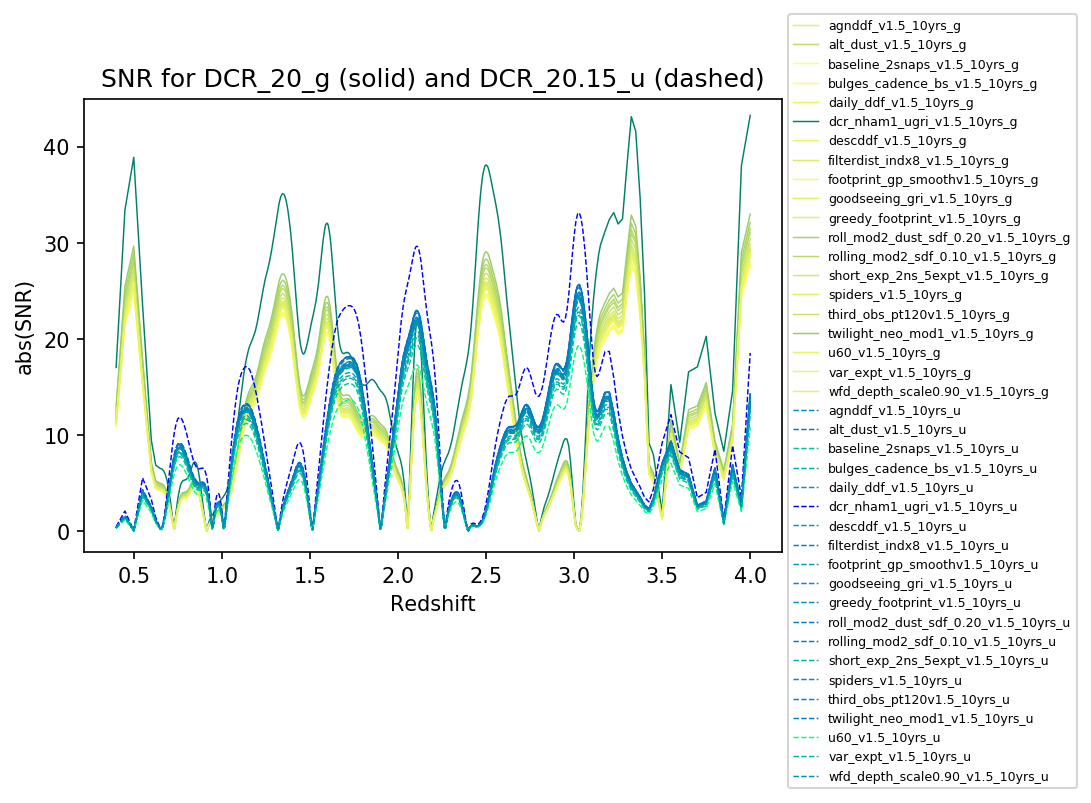

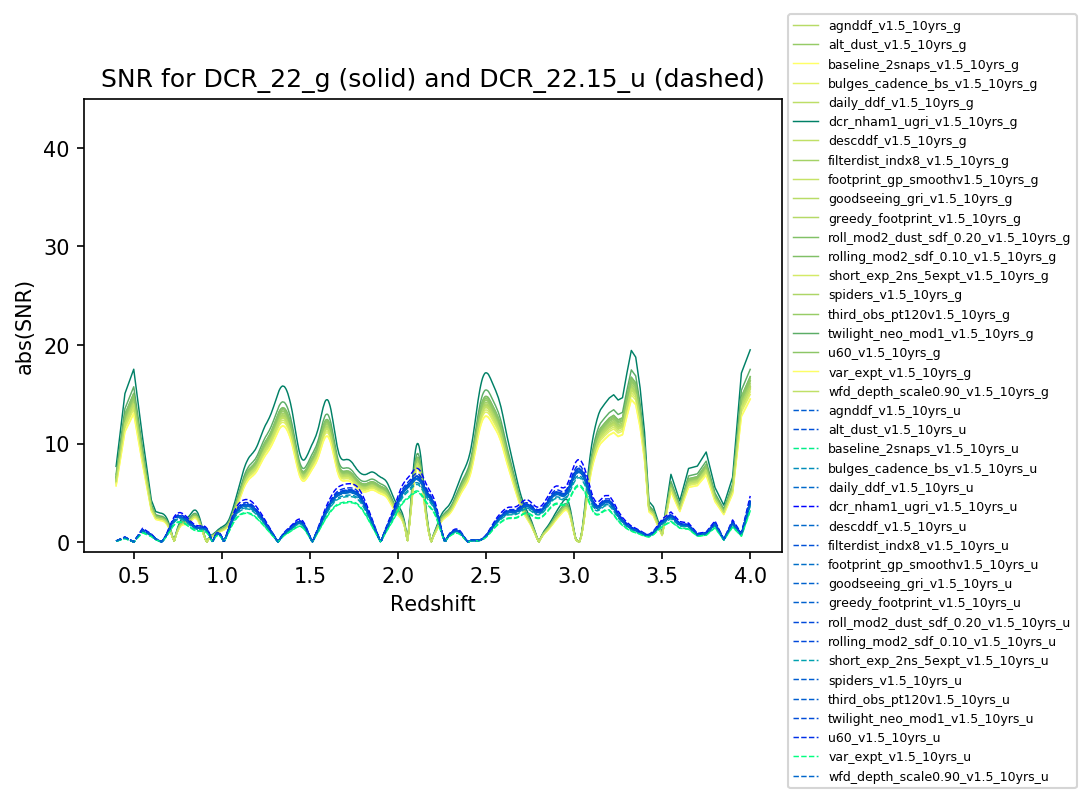

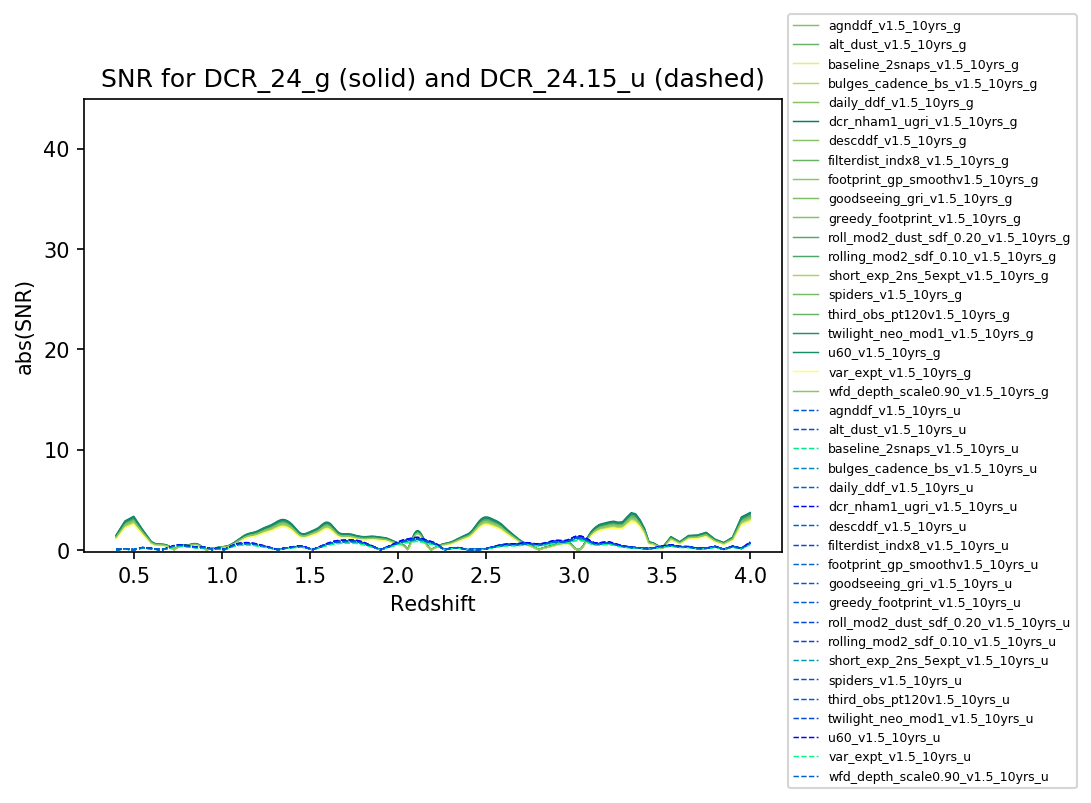

In [12]:
gmags = [20, 22, 24]
ylim = 45 # replace with None for uniform ylim in the below plots
savefig = False # change to True if want to save figure named by title

for j, key in enumerate(bd_keys):
        
    if j < 3:
        
        gKey = [elem for elem in bd_keys if elem[1] == f'DCR_{gmags[j]}_g'][0]
        uKey = [elem for elem in keys if elem[1] == f'DCR_{gmags[j]+0.15}_u'][0]
#         uKey = (j+4, f'DCR_{gmags[j]+0.15}_u') # corresponding u band key 
        mds_g = get_metric_medians(gKey, bundleDicts, get_dcr_median)
        mds_u = get_metric_medians(uKey, bundleDicts, get_dcr_median)

        # create normalization object
        gNorm = mpl.colors.LogNorm(vmin=np.min(mds_g), vmax=np.max(mds_g))
        uNorm = mpl.colors.LogNorm(vmin=np.min(mds_u), vmax=np.max(mds_u))
    
        fig = plt.figure(dpi=150)
        
        # seperate loops for u and g to keep the legend clean
        for i, run in enumerate(resultDbsView):
                        
            # look for the correct combination of metricID and metricName 
            keys = [*bundleDicts[run].keys()]
            metricKeyG = [elem for elem in keys if elem[1] == gKey[1]][0]
            md_g = get_dcr_median(bundleDicts[run][metricKeyG])

            plt.plot(dfDCR['zshifts'].values, np.abs(dfDCR['g-slope']/md_g), \
                     color=mpl.cm.summer(gNorm(md_g)), linewidth=0.7, label=f'{run}_g')
        
        # seperate loops for u and g to keep the legend clean
        for i, run in enumerate(resultDbsView):

            # look for the correct combination of metricID and metricName 
            keys = [*bundleDicts[run].keys()]
            metricKeyU = [elem for elem in keys if elem[1] == uKey[1]][0]
            md_u = get_dcr_median(bundleDicts[run][metricKeyU])

            plt.plot(dfDCR['zshifts'].values, np.abs(dfDCR['u-slope']/md_u), linestyle='--', \
                     color=mpl.cm.winter(uNorm(md_u)), linewidth=0.7, label=f'{run}_u')
        
        # option to set uniform ylim
        if ylim is not None:
            plt.ylim(top=ylim)
        
        plt.legend(fontsize=6, loc='best', bbox_to_anchor=(1., 1.2))
        plt.title(f'SNR for {gKey[1]} (solid) and {uKey[1]} (dashed)')
        plt.xlabel("Redshift")
        plt.ylabel("abs(SNR)")
        
        # options to save
        if savefig:
            plt.savefig(f'SNR for {gKey[1]} and {uKey[1]}.png', dpi=200)

### 2.3 SkyPlots
Show the slope uncertainty over the sky

In [13]:
# function to make sky plot
import healpy as hp
def plotSky_scale(mb, scale_func=np.log10, minVal=None, maxVal=None, **kwargs):
    '''
    Plot High-Res DDF skymap. 
    Args:
        mb: MetricBundle object.
        scale_func (func): A scaling function for the metric data, e.g., np.log10
        minVal (float): Mininum value to plot
        maxVal (float): Maximum value to plot
    '''
    
    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        dirty_data = mbValues.data[~mask]
        data = dirty_data[~(np.isnan(dirty_data) | np.isinf(dirty_data))]
        nData = scale_func(data)
    except Exception as e:
        print(e)
        return None
    
    if maxVal is None:
        maxVal = np.percentile(nData, 99)
    if minVal is None: 
        minVal = np.percentile(nData, 1)
        
    _ = hp.mollview(scale_func(mbValues), flip='astro', max=maxVal, min=minVal, **kwargs)

    _ = hp.graticule(dpar=30, dmer=30, verbose=False)
    plt.title(f'Metric:{mb.metric.name}, RunName:{mb.runName}', fontsize=15)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


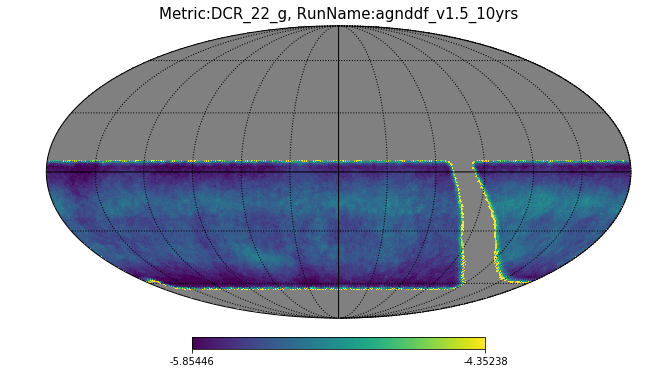

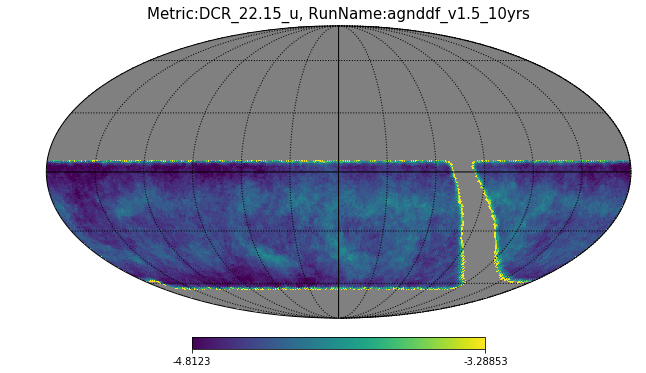

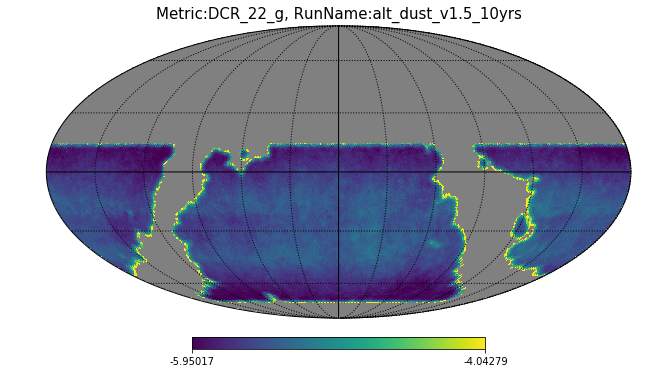

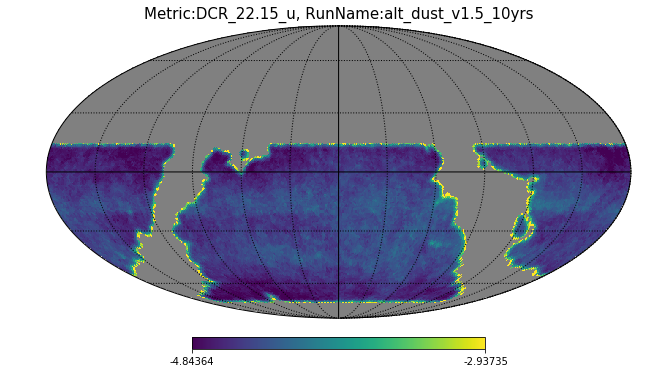

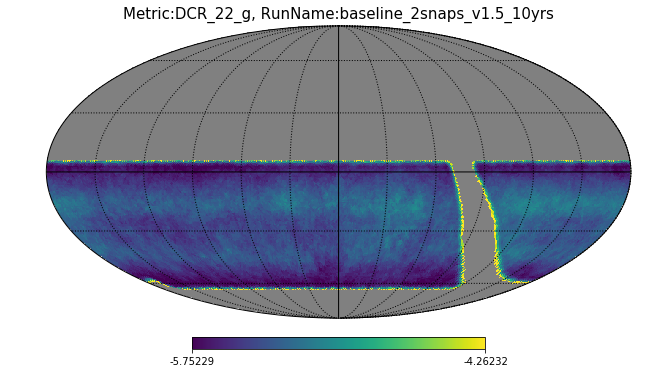

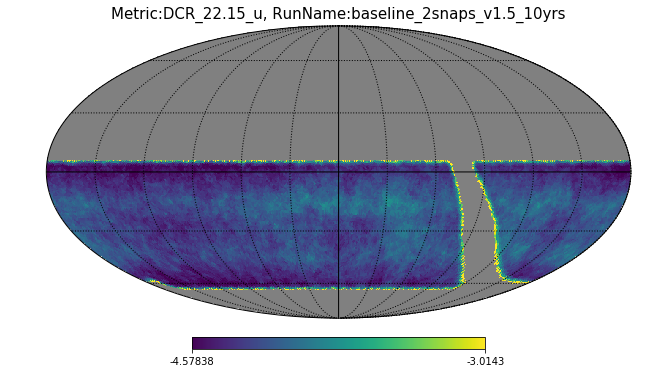

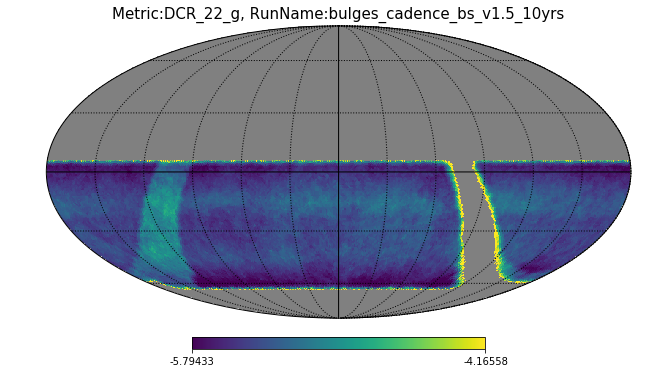

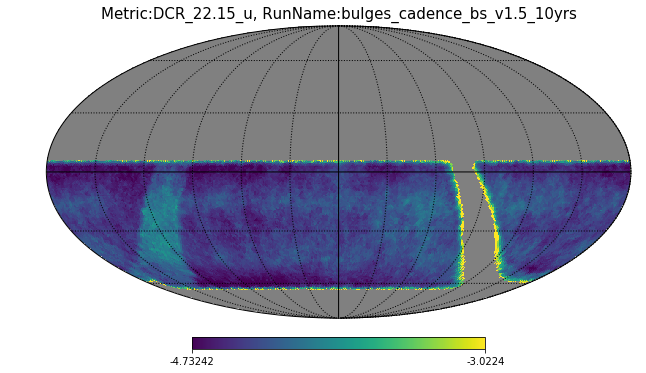

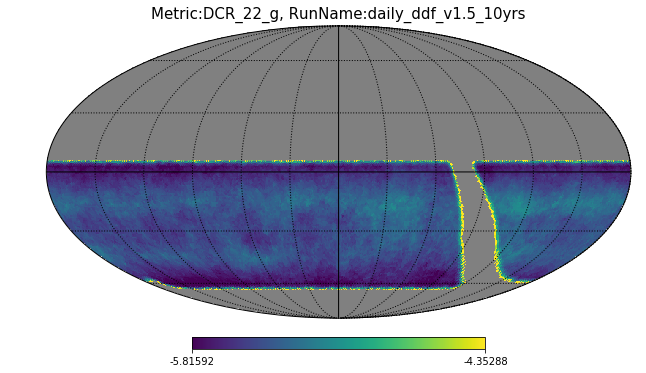

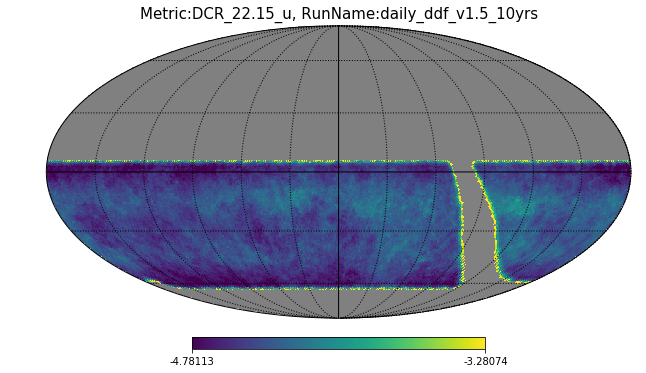

In [16]:
# only plotting first few opsims to save space
for k, run in enumerate(resultDbsView):
    if k < 5: # Make smaller to only plot a few examples
        
        # only plotting gmag = 21 metrics
        for i, gmag in enumerate(gmags[1:2]):
            
            if i < 3:
                # don't worry about the first integer in the key
                # below, only to fill space
                gKey = (i+1, f'DCR_{gmag}_g')
                uKey = (i+1+4, f'DCR_{gmags[i+1]+0.15}_u')

                # look for the correct combination of metricID and metricName 
                keys = [*bundleDicts[run].keys()]
                metricKeyG = [elem for elem in keys if elem[1] == gKey[1]][0]
                metricKeyU = [elem for elem in keys if elem[1] == uKey[1]][0]

                #plotSky_scale(bundleDicts[run][metricKeyG], np.log, maxVal=-4.5, minVal=-6.5) # uniform lim
                plotSky_scale(bundleDicts[run][metricKeyG], np.log)
                plotSky_scale(bundleDicts[run][metricKeyU], np.log)